In [1]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt
%matplotlib inline

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import pynapple as nap

In [2]:
sess_name="e15_13f1_220117"#'e13_26m1_210913'#
data_dir_full = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117"#'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913' #
py_data_dir = os.path.join(data_dir_full,"py_data")
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr_df=  fr_['df']
fr_pyr = fr_['df']['pyr']
fr_int = fr_['df']['int']
fr_map_trial = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']
cell_cols_pyr=np.array(cell_cols['pyr'],dtype=object)
cell_cols_int =np.array(cell_cols['int'],dtype=object)


In [3]:
data_dir_full = data_dir_full
to_return=prep.load_stuff(data_dir_full)

cell_metrics=to_return['cell_metrics']
behavior=to_return['behavior']
ripple_events=to_return['ripple_events']
mergepoints=to_return['mergepoints']
cell_type_mask=to_return['cell_type_mask']
pyr_uid=to_return['pyr_uid']

trial_ind_d = {ch:np.nonzero(behavior.trials.visitedArm==ch)[0] for ch in [0,1]}
dt = np.diff(behavior.timestamps).mean()

In [4]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering



In [14]:
import math_functions as mf

In [226]:
# target_toy = mf.unnormalized_normal_pdf(np.arange(100),loc=20,scale=20)
sig=5
target_toy = scipy.stats.norm.pdf(np.arange(100),loc=20,scale=sig)
# target_toy = target_toy/target_toy.sum()

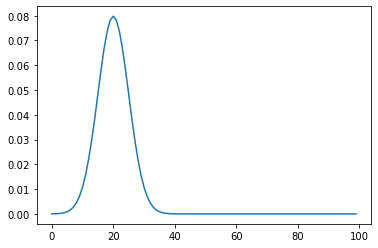

In [227]:
plt.plot(target_toy)

In [228]:
# def loss(mu,target_toy):
#     yhat = mf.unnormalized_normal_pdf(xs,loc=mu,scale=20)
#     return ((yhat-target_toy)**2).sum()

def loss(sigma,target_toy):
    yhat = mf.unnormalized_normal_pdf(xs,loc=mu,scale=sigma)
    return ((yhat-target_toy)**2).sum()
    

In [206]:
import jax

In [236]:
mu_pred = 20.
sigma_pred = 1.
xs=np.arange(100)
ii = 0
max_iter = 100
loss_l=[]
grad_l=[]
mu_l=[]
sigma_l = []
lr = 1
# yhat = mf.unnormalized_normal_pdf(xs,loc=mu_pred,scale=20)
yhat = scipy.stats.norm.pdf(xs,loc=mu_pred,scale=sigma_pred)
# yhat = yhat / yhat.sum()
while np.abs(yhat-target_toy).sum() > 0.01 and ii < max_iter:
#     yhat = mf.unnormalized_normal_pdf(xs,loc=mu_pred,scale=20)
    yhat = scipy.stats.norm.pdf(xs,loc=mu_pred,scale=sigma_pred)
#     yhat = yhat / yhat.sum()
    
#     mu_pred = np.sum((target_toy - yhat)*yhat*xs) / np.sum((target_toy - yhat)*yhat)
#     mu_pred = np.sum((target_toy - yhat)*xs) / np.sum(target_toy - yhat)
    sigma_pred = np.sqrt(np.sum((target_toy*(xs-mu_pred)**2)) / np.sum(target_toy))
    sigma_l.append(sigma_pred)
#     mu_pred = np.sum(target_toy * xs) / np.sum(target_toy)
#     mu_l.append(mu_pred)
    l = ((yhat-target_toy)**2).sum()
    loss_l.append(l)
#     g = np.squeeze(jax.grad(loss,0)(mu_pred,target_toy))
#     grad_l.append(g)
#     mu_pred -= g * lr
    ii+=1

In [237]:
sigma_l

[4.999105799364688, 4.999105799364688]

In [209]:
jax.grad(loss,0)(19.,target_toy)

DeviceArray(0.37585223, dtype=float32)

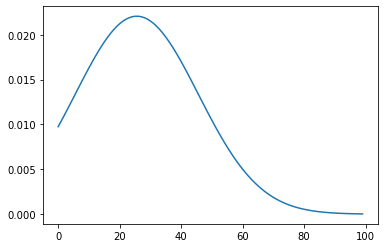

In [210]:
plt.plot(yhat)
# plt.plot(grad_l)
# plt.plot(loss_l)

In [220]:
xs_circular = np.cos(xs / len(xs) * 2 * np.pi)

In [221]:
xs_phases = xs / len(xs) * 2 * np.pi

In [222]:
np.argmin(np.abs(xs_phases-1.27))

20

In [223]:
mu_phase=np.arccos(np.sum(target_toy * xs_circular) / np.sum(target_toy))
mu_pred = np.argmin(np.abs(xs_phases-mu_phase))

In [264]:
from jax import jit, vmap
from math_functions import unnormalized_normal_pdf

In [265]:
# @jit
def forward_one_neuron(regressors, par, nfields_mask, common_mu=False, common_sigma=False):
    SIGMA_MIN =3. # careful!!!

#     par = par_invtransform(par_trans,common_mu,common_sigma)
    mus_l = par['mus']
    sigmas_l = par['sigmas']
    ws_l = par['ws']
    b_l = par['b']
    
    ntrials,nfields = ws_l.shape
    
    xs = regressors['xs']
    xs_l = np.tile(xs[:,None],[1,ntrials])

    one_field_func=lambda mus,sigmas,ws:unnormalized_normal_pdf(xs_l,loc=mus,scale=sigmas + SIGMA_MIN) * ws # should be the corresponding mus[:,k], ntrials,
    multi_field_res = vmap(one_field_func,in_axes=(1,1,1))(mus_l,sigmas_l,ws_l)
    fr_all_trial_one_field_l_masksum = np.einsum('f,fpt->pt',nfields_mask,multi_field_res)
    multi_field_res_final = fr_all_trial_one_field_l_masksum + np.squeeze(b_l)
    
    return multi_field_res_final

def forward_population(regressors, par_l, nfields_mask_l,common_mu=False,common_sigma=False):
    return vmap(forward_one_neuron,in_axes=(None,0,0,None,None))(regressors,par_l,nfields_mask_l,common_mu,common_sigma)



In [275]:
import gm
reload(gm)

<module 'gm' from '/mnt/home/szheng/projects/util_code/gm.py'>

In [266]:
rngkey=jax.random.PRNGKey(0)
n_neurons = 10
rngkey_l = jax.random.split(rngkey,n_neurons)

n_trials = 2
regressors = gm.get_regressors({'ntrials':n_trials})
nfields_max = 4

par_l,_ = gm.init_population(rngkey_l,regressors,nfields_max)

reg_par_l = gm.get_reg_pars_population(n_neurons)

In [271]:
gm.forward_population(regressors, par_l, reg_par_l['nfields_mask'],common_mu=False,common_sigma=False)

DeviceArray([[[ 3.4244702 ,  3.608725  ],
              [ 3.770956  ,  3.665818  ],
              [ 4.189477  ,  3.7395346 ],
              ...,
              [ 2.2519426 ,  3.441004  ],
              [ 2.2519426 ,  3.4401157 ],
              [ 2.2519426 ,  3.4395742 ]],

             [[ 1.4037936 ,  2.2183397 ],
              [ 1.4985193 ,  2.2183962 ],
              [ 1.6298454 ,  2.218481  ],
              ...,
              [ 1.1980081 ,  2.4145303 ],
              [ 1.1980081 ,  2.3661978 ],
              [ 1.1980081 ,  2.3290157 ]],

             [[ 5.796296  ,  2.0490918 ],
              [ 6.3293743 ,  2.125113  ],
              [ 6.9486647 ,  2.2216842 ],
              ...,
              [ 3.3361404 ,  4.50611   ],
              [ 3.3361294 ,  4.0403533 ],
              [ 3.3361228 ,  3.6425815 ]],

             ...,

             [[ 2.2333639 ,  6.3631887 ],
              [ 2.2518048 ,  7.313836  ],
              [ 2.279037  ,  8.3779545 ],
              ...,
              [11

In [277]:
field_to_leave_index =None
n_positions = len(regressors['xs'])
target = np.ones((n_neurons,n_positions, n_trials))
get_resid_leave_one_field(target,regressors,par_l,reg_par_l['nfields_mask'],field_to_leave_index)

DeviceArray([[[-1.2856181 , -2.440458  ],
              [-1.3171504 , -2.4416804 ],
              [-1.3732955 , -2.4437244 ],
              ...,
              [-1.2519426 , -2.4388027 ],
              [-1.2519426 , -2.4388027 ],
              [-1.2519426 , -2.4388027 ]],

             [[-0.19816303, -1.2182341 ],
              [-0.19840205, -1.2182341 ],
              [-0.198977  , -1.2182341 ],
              ...,
              [-0.19800806, -1.2211778 ],
              [-0.19800806, -1.2200196 ],
              [-0.19800806, -1.2193031 ]],

             [[-2.6176114 , -0.81076443],
              [-2.7427466 , -0.81325924],
              [-2.9146636 , -0.8172591 ],
              ...,
              [-2.336114  , -1.1896522 ],
              [-2.336114  , -1.081222  ],
              [-2.336114  , -1.0012069 ]],

             ...,

             [[-1.200458  , -1.337584  ],
              [-1.2004609 , -1.7592511 ],
              [-1.2004702 , -2.3132203 ],
              ...,
              [-4

In [484]:
EPS = 1e-8
def w_step(target_resid, y_pred_no_w):
    '''
    target_resid: n_neurons x n_pos x n_trials
    y_pred_no_w: n_neurons x n_pos x n_trials
    '''
    w_new = np.einsum('npt,npt->nt',target_resid,y_pred_no_w ) / (np.einsum('npt,npt->nt',y_pred_no_w, y_pred_no_w)+EPS)
    return w_new

def b_step(target_resid):
    '''
    ==
    b_new: n_neurons x n_trials x 1
    '''
    b_new = target_resid.mean(axis=1)
    return b_new[:,:,None] # add a feature dim

def sigma_step(target_resid,xs,mu):
    '''
    xs: n_pos
    mu: n_neurons x ntrials
    '''
    deviation_squared = (np.subtract.outer(xs,mu))**2 # n_pos x n_neurons x n_trials
    sigma_new = np.einsum('npt,pnt->nt',target_resid,deviation_squared) / np.sum(target_resid,axis=1)
    sigma_new = np.sqrt(sigma_new)
    return sigma_new

def mu_step(target_resid,xs):
    '''
    target_resid: n_neurons x n_pos x n_trials
    mus: n_neurons x ntrials x n_fields_max
    nfields_mask_l: n_neurons x n_fields_max 
    '''
    mu_new = np.einsum('npt,p->nt',target_resid,xs) / np.sum(target_resid,axis=1)
    return mu_new


def get_resid_leave_one_field(target,regressors,par_l,nfields_mask_l,field_to_leave_index):
    '''
    nfields_mask_l: n_neurons x n_fields_max
    '''
    if field_to_leave_index is not None: # if None then only leaving the baseline
        nfields_mask_l = nfields_mask_l.at[:,field_to_leave_index].set(0)
    y_hat_leave_one_field = gm.forward_population(regressors, par_l, nfields_mask_l,common_mu=False,common_sigma=False)

    target_resid = target - y_hat_leave_one_field
    return target_resid,y_hat_leave_one_field
    
    
def forward_no_w_one_field(xs,mu,sigma):
    '''
    xs: n_pos
    mu: n_neurons x n_trials
    sigma: n_neurons x n_trials
    '''
    res = np.exp(-(np.subtract.outer(xs,mu))**2 / (2 * sigma[None,:,:]**2)) # n_pos x n_neurons x n_trials
    res =np.swapaxes(res,0,1)
    return res
    
def correct_for_negative_resid_one_neuron_one_trial(target,y_hat_leave_one_field,par):
    '''
    target: npos
    '''
    do_correction = np.any(target < y_hat_leave_one_field)
    def correction_func():
        ratio = np.max(y_hat_leave_one_field / (target + EPS)) # get the largest ratio
#         ratio = np.max(y_hat_leave_one_field) / np.max(target + EPS) # get the largest ratio
#         ws_new= par['ws'] / ratio # somehow this is not allowed, because this is used to modify par['ws']outside??
#         b_new = par['b'] / ratio
#         return ws_new,b_new
        return ratio
    def same_func():
#         return par['ws'],par['b']
        return np.array(1.)
        
#     same_func = lambda x:x
    ratio = jax.lax.cond(do_correction, correction_func,same_func)
    ws_new = par['ws']/ratio
    b_new = par['b']/ratio
    par['ws'] = par['ws'].at[:].set(ws_new)
    par['b'] = par['b'].at[:].set(b_new)
    
    
    return par
    
    
    
def correct_for_negative_resid(target,y_hat_leave_one_field,par_l):
    
    par_l = vmap(vmap(correct_for_negative_resid_one_neuron_one_trial,in_axes=(0,0,0)),in_axes=(-1,-1,1))(target,y_hat_leave_one_field,par_l)
    return par_l
    
    
def fit_one_field_step(target,regressors,par_l,nfields_mask_l,field_to_leave_index):
    target_resid,y_hat_leave_one_field = get_resid_leave_one_field(target,regressors,par_l,nfields_mask_l,field_to_leave_index)
    par_l = correct_for_negative_resid(target,y_hat_leave_one_field,par_l)
    target_resid,y_hat_leave_one_field = get_resid_leave_one_field(target,regressors,par_l,nfields_mask_l,field_to_leave_index)
#     import pdb
#     pdb.set_trace()
    xs = regressors['xs']
    mu_new = mu_step(target_resid,xs)
    sigma_new = sigma_step(target_resid,xs,mu_new)
    y_pred_no_w = forward_no_w_one_field(xs,mu_new,sigma_new)
    ws_new = w_step(target_resid,y_pred_no_w)
    par_l['mus'] = par_l['mus'].at[:,:,field_to_leave_index].set(mu_new)
    par_l['sigmas'] = par_l['sigmas'].at[:,:,field_to_leave_index].set(sigma_new)
    par_l['ws'] = par_l['ws'].at[:,:,field_to_leave_index].set(ws_new)
    return par_l
    
def fit_baseline_step(target,regressors,par_l,nfields_mask_l):
    target_resid,y_hat_leave_baseline = get_resid_leave_one_field(target,regressors,par_l,nfields_mask_l,None)
#     par_l = correct_for_negative_resid(target,y_hat_leave_baseline,par_l)
#     target_resid,y_hat_leave_baseline = get_resid_leave_one_field(target,regressors,par_l,nfields_mask_l,None)
    b_new = b_step(target_resid)
    par_l['b'] = b_new
    return par_l

def smooth_params():
    pass

def fit_gibbs():
    pass
    

In [504]:
# target = scipy.stats.norm.pdf(xs,loc=30,scale=5) * 1. + scipy.stats.norm.pdf(xs,loc=60,scale=5) * 2.
target = unnormalized_normal_pdf(xs,loc=30,scale=5) * 10. + unnormalized_normal_pdf(xs,loc=80,scale=5) * 20.
target = target[None,:,None]

rngkey=jax.random.PRNGKey()
n_neurons = 1
rngkey_l = jax.random.split(rngkey,n_neurons)

n_trials = 1
regressors = gm.get_regressors({'ntrials':n_trials})
nfields_max = 2

par_l,_ = gm.init_population(rngkey_l,regressors,nfields_max,range_dict={'ws':[0,40],'b':[0,4],'sigmas':[1,2],'mus':[10,90]})

reg_par_l = gm.get_reg_pars_population(n_neurons,reg_pars_={'nfields':2,'nfields_max':nfields_max})

In [505]:
nfields_mask_l = reg_par_l['nfields_mask']
field_to_leave_index = 0
par_fit = par_l
for i in range(5):
    for field_to_leave_index in range(nfields_max):
        par_fit =fit_one_field_step(target,regressors,par_fit,nfields_mask_l,field_to_leave_index)
    par_fit=fit_baseline_step(target,regressors,par_fit,nfields_mask_l)

In [506]:
fit_one_field_step(target,regressors,par_fit,nfields_mask_l,0)


{'b': DeviceArray([[[1.1840245e-07]]], dtype=float32),
 'b_bar': DeviceArray([[[0.32249737]]], dtype=float32),
 'mus': DeviceArray([[[63.332165, 63.332172]]], dtype=float32),
 'mus_bar': DeviceArray([[[83.08445, 83.9159 ]]], dtype=float32),
 'sigmas': DeviceArray([[[24.09419 , 24.094193]]], dtype=float32),
 'sigmas_bar': DeviceArray([[[1.9239488, 1.9135556]]], dtype=float32),
 'ws': DeviceArray([[[5.8156667e+00, 1.3891175e-06]]], dtype=float32),
 'ws_bar': DeviceArray([[[36.95795 , 36.542225]]], dtype=float32)}

In [497]:
target_resid,y_hat_leave_one_field = get_resid_leave_one_field(target,regressors,par_fit,nfields_mask_l,0)



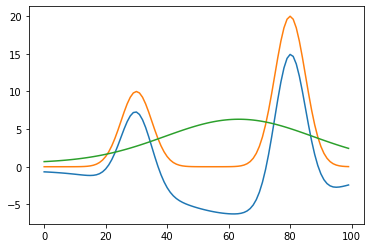

In [503]:
plt.plot(target_resid.flatten())
plt.plot(target.flatten())
plt.plot(y_hat_leave_one_field.flatten())

In [495]:
par_fit

{'b': DeviceArray([[[0.49570236]]], dtype=float32),
 'b_bar': DeviceArray([[[0.32249737]]], dtype=float32),
 'mus': DeviceArray([[[63.332165, 63.332172]]], dtype=float32),
 'mus_bar': DeviceArray([[[83.08445, 83.9159 ]]], dtype=float32),
 'sigmas': DeviceArray([[[24.09419 , 24.094193]]], dtype=float32),
 'sigmas_bar': DeviceArray([[[9.467642, 9.39489 ]]], dtype=float32),
 'ws': DeviceArray([[[5.1359198e-06, 5.8156638e+00]]], dtype=float32),
 'ws_bar': DeviceArray([[[36.95795 , 36.542225]]], dtype=float32)}

In [360]:
par_fit

{'b': DeviceArray([[0.00517921]], dtype=float32),
 'b_bar': DeviceArray([[[0.32249737]]], dtype=float32),
 'mus': DeviceArray([[[45.636032]]], dtype=float32),
 'mus_bar': DeviceArray([[[16.449947]]], dtype=float32),
 'sigmas': DeviceArray([[[27.083403]]], dtype=float32),
 'sigmas_bar': DeviceArray([[[3.5643704]]], dtype=float32),
 'ws': DeviceArray([[[0.07154378]]], dtype=float32),
 'ws_bar': DeviceArray([[[3.2249737]]], dtype=float32)}

In [367]:
target_resid,y_hat_leave_one_field = get_resid_leave_one_field(target,regressors,par_fit,nfields_mask_l,field_to_leave_index)
mu_new = mu_step(target_resid,xs)

In [372]:
mm = np.any(y_hat_leave_one_field > target,axis=1)

In [302]:
target_resid = get_resid_leave_one_field(target,regressors,par_l,nfields_mask_l,field_to_leave_index)
xs = regressors['xs']
mu_new = mu_step(target_resid,xs)
sigma_new = sigma_step(target_resid,xs,mu_new)
y_pred_no_w = forward_no_w_one_field(xs,mu_new,sigma_new)
ws_new = w_step(target_resid,y_pred_no_w)

/tmp/ipykernel_814610/2189491552.py:25: RuntimeWarning: invalid value encountered in sqrt
  sigma_new = np.sqrt(sigma_new)


In [305]:
target = np.squeeze(target)
np.sum(target * xs) / target.sum()

DeviceArray(30.000002, dtype=float32)